In [2]:
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# 1) Load precomputed features
train_data = np.load("train_features_augmented_no_sad.npz", allow_pickle=True)
X_train, y_train = train_data["data"], train_data["labels"]

val_data = np.load("val_features_no_sad.npz", allow_pickle=True)
X_val, y_val = val_data["data"], val_data["labels"]

# 2) Drop "sad" samples
mask_train = np.array(y_train) != "sad"
mask_val = np.array(y_val) != "sad"
X_train = X_train[mask_train]
y_train = y_train[mask_train]
X_val = X_val[mask_val]
y_val = y_val[mask_val]

# 3) Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_train_oh = to_categorical(y_train_enc)
y_val_oh = to_categorical(y_val_enc)
joblib.dump(le, "label_encoder_no_sad.pkl")

# 4) Normalize
max_val = np.max(np.abs(X_train))
np.save("../models/max_val_no_sad.npy", max_val)
X_train = X_train / max_val
X_val = X_val / max_val

# 5) Reshape to (batch, 130, 120)
X_train = X_train.reshape(X_train.shape[0], 130, 120)
X_val = X_val.reshape(X_val.shape[0], 130, 120)

# 6) Compute class weights
class_ids = np.argmax(y_train_oh, axis=1)
weights = compute_class_weight("balanced", classes=np.unique(class_ids), y=class_ids)
class_weight = dict(enumerate(weights))

# 7) Define CNN model
model = Sequential([
    Input(shape=(130, 120)),

    Conv1D(64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Flatten(),
    Dense(len(le.classes_), activation='softmax')  # Adjusted output layer size
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 8) Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=0.5, verbose=1)

# 9) Train
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=60,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stop, lr_reduce]
)

# 10) Save model
model.save("cnn_emotion_model_no_sad.h5")

# 11) Evaluate
val_loss, val_acc = model.evaluate(X_val, y_val_oh)
print(f"\nCNN Validation Accuracy (no 'sad'): {val_acc:.4f}")


Epoch 1/60
208/208 [==============================] - 13s 39ms/step - loss: 2.3159 - accuracy: 0.2899 - val_loss: 2.4752 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/60
208/208 [==============================] - 7s 36ms/step - loss: 1.7476 - accuracy: 0.4461 - val_loss: 2.2746 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 3/60
208/208 [==============================] - 7s 36ms/step - loss: 1.5265 - accuracy: 0.5241 - val_loss: 1.9345 - val_accuracy: 0.4447 - lr: 0.0010
Epoch 4/60
208/208 [==============================] - 8s 36ms/step - loss: 1.3658 - accuracy: 0.5809 - val_loss: 1.2492 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 5/60
208/208 [==============================] - 8s 37ms/step - loss: 1.2621 - accuracy: 0.6170 - val_loss: 1.1153 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 6/60
208/208 [==============================] - 7s 36ms/step - loss: 1.1415 - accuracy: 0.6616 - val_loss: 1.0684 - val_accuracy: 0.6635 - lr: 0.0010
Epoch 7/60
208/208 [==============================] - 7s 36ms/s

C:\Users\lenovo 6pin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 0s 10ms/step - loss: 0.8017 - accuracy: 0.7957

CNN Validation Accuracy (no 'sad'): 0.7957


In [3]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import numpy as np

# Get predicted probabilities and convert to class indices
y_pred_prob = model.predict(X_val)
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_val_oh, axis=1)

# Overall Accuracy
val_acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"\nValidation Accuracy: {val_acc:.4f}")

# Weighted F1 Score
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

# Per-Class Accuracy
cm = confusion_matrix(y_true_labels, y_pred_labels)
class_wise_acc = cm.diagonal() / cm.sum(axis=1)

print("\nPer-Class Accuracy:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {class_wise_acc[i]:.4f}")


13/13 [==============================] - 1s 12ms/step

Validation Accuracy: 0.7957
Weighted F1 Score: 0.7959

Classification Report:
              precision    recall  f1-score   support

       angry       0.85      0.91      0.88        75
        calm       0.87      0.73      0.80        75
     disgust       0.72      0.74      0.73        39
     fearful       0.81      0.81      0.81        75
       happy       0.81      0.75      0.78        75
     neutral       0.65      0.87      0.74        38
   surprised       0.76      0.74      0.75        39

    accuracy                           0.80       416
   macro avg       0.78      0.79      0.78       416
weighted avg       0.80      0.80      0.80       416


Per-Class Accuracy:
angry: 0.9067
calm: 0.7333
disgust: 0.7436
fearful: 0.8133
happy: 0.7467
neutral: 0.8684
surprised: 0.7436


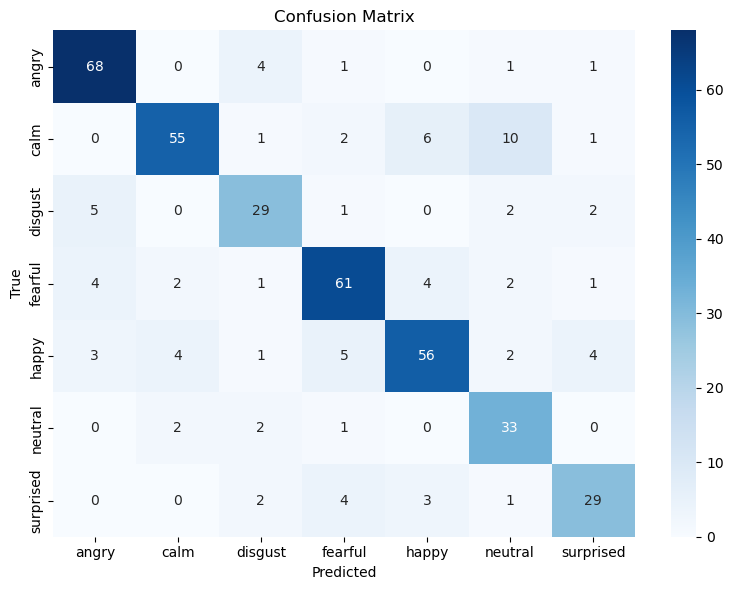

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

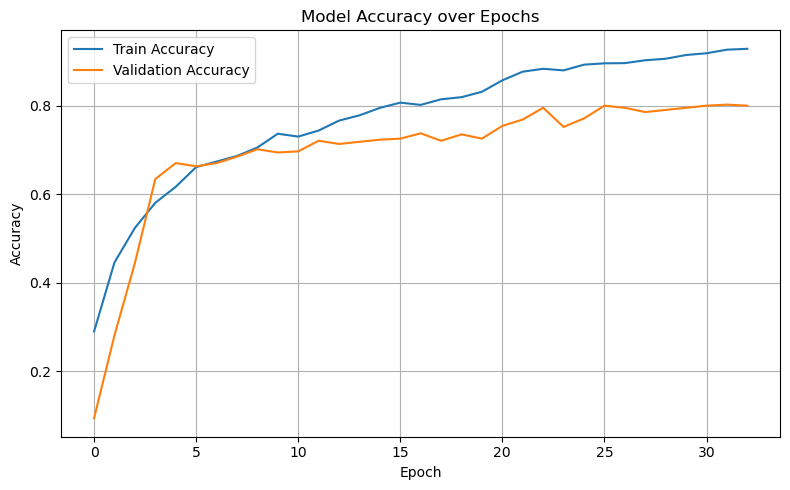

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

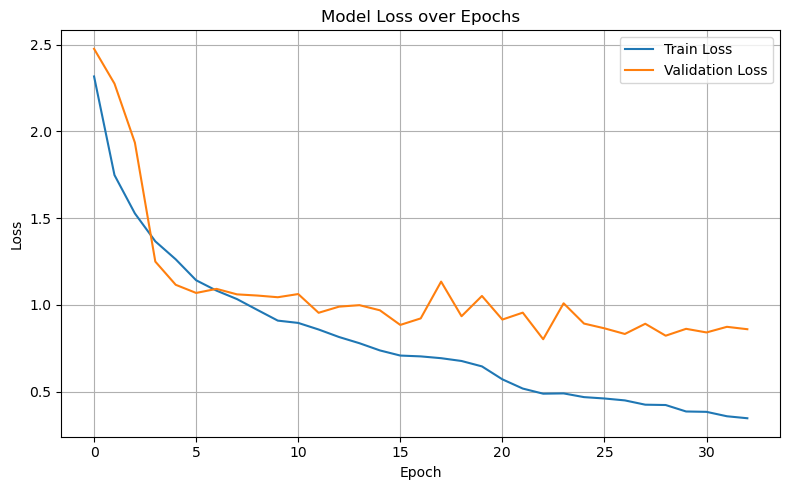

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
